### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


### 1. Load the Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Check what the max, min and mean time values are. This will help us in defining the 'next_step' function in the Environment.

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Since the max time is 11 hours between any 2 points, the next state of the cab driver may increase at most by  1 day.

### 2. Agent Class

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
         
        self.state_size = state_size
        self.action_size = action_size

        
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
 
        input_shape = self.state_size
        model = Sequential()
               
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
             
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

### 3. DQN block

In [5]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### 4. Run the episodes, build up replay buffer and train the model.
### Note:
#### The moment total episode time exceeds 720 (30 days), we ignore the most recent ride and do NOT save that experience in the replay memory
#### The init state is randomly picked from the state space for each episode

In [6]:
start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)


Saving Model 0
episode 9, reward 122.0, memory_length 1353, epsilon 0.9955001547284723 total_time 730.0
episode 19, reward -376.0, memory_length 2000, epsilon 0.9905350769930761 total_time 725.0
episode 29, reward -193.0, memory_length 2000, epsilon 0.9855947626861951 total_time 726.0
episode 39, reward -270.0, memory_length 2000, epsilon 0.9806790882997144 total_time 721.0
episode 49, reward -247.0, memory_length 2000, epsilon 0.9757879309415182 total_time 727.0
episode 59, reward -186.0, memory_length 2000, epsilon 0.9709211683324178 total_time 722.0
episode 69, reward -580.0, memory_length 2000, epsilon 0.9660786788030947 total_time 729.0
episode 79, reward -79.0, memory_length 2000, epsilon 0.9612603412910584 total_time 727.0
episode 89, reward -296.0, memory_length 2000, epsilon 0.9564660353376199 total_time 722.0
episode 99, reward -94.0, memory_length 2000, epsilon 0.9516956410848808 total_time 725.0
episode 109, reward -250.0, memory_length 2000, epsilon 0.9469490392727365 tota

episode 919, reward 631.0, memory_length 2000, epsilon 0.631593050259626 total_time 726.0
episode 929, reward 327.0, memory_length 2000, epsilon 0.6284429667796988 total_time 721.0
episode 939, reward 390.0, memory_length 2000, epsilon 0.6253085944066726 total_time 723.0
episode 949, reward 281.0, memory_length 2000, epsilon 0.6221898547810748 total_time 722.0
episode 959, reward 619.0, memory_length 2000, epsilon 0.6190866699342522 total_time 725.0
episode 969, reward 172.0, memory_length 2000, epsilon 0.6159989622864221 total_time 721.0
episode 979, reward 385.0, memory_length 2000, epsilon 0.6129266546447325 total_time 722.0
episode 989, reward 224.0, memory_length 2000, epsilon 0.6098696702013323 total_time 724.0
episode 999, reward 290.0, memory_length 2000, epsilon 0.6068279325314512 total_time 725.0
Saving Model 1000
episode 1009, reward 345.0, memory_length 2000, epsilon 0.6038013655914889 total_time 724.0
episode 1019, reward 416.0, memory_length 2000, epsilon 0.60078989371711

episode 1809, reward 919.0, memory_length 2000, epsilon 0.40474015917966877 total_time 721.0
episode 1819, reward 721.0, memory_length 2000, epsilon 0.4027215092142031 total_time 724.0
episode 1829, reward 1325.0, memory_length 2000, epsilon 0.4007129273074429 total_time 727.0
episode 1839, reward 988.0, memory_length 2000, epsilon 0.39871436324473586 total_time 721.0
episode 1849, reward 937.0, memory_length 2000, epsilon 0.3967257670618763 total_time 725.0
episode 1859, reward 793.0, memory_length 2000, epsilon 0.3947470890438561 total_time 722.0
episode 1869, reward 1161.0, memory_length 2000, epsilon 0.3927782797236218 total_time 722.0
episode 1879, reward 1227.0, memory_length 2000, epsilon 0.3908192898808378 total_time 727.0
episode 1889, reward 1067.0, memory_length 2000, epsilon 0.388870070540656 total_time 721.0
episode 1899, reward 1420.0, memory_length 2000, epsilon 0.38693057297249134 total_time 725.0
episode 1909, reward 728.0, memory_length 2000, epsilon 0.385000748688803

episode 2689, reward 1370.0, memory_length 2000, epsilon 0.26066740358669477 total_time 722.0
episode 2699, reward 1008.0, memory_length 2000, epsilon 0.25936731948751673 total_time 725.0
episode 2709, reward 1164.0, memory_length 2000, epsilon 0.2580737195848345 total_time 723.0
episode 2719, reward 1321.0, memory_length 2000, epsilon 0.25678657153858325 total_time 721.0
episode 2729, reward 1304.0, memory_length 2000, epsilon 0.2555058431699948 total_time 722.0
episode 2739, reward 1480.0, memory_length 2000, epsilon 0.25423150246079323 total_time 722.0
episode 2749, reward 1659.0, memory_length 2000, epsilon 0.2529635175523944 total_time 727.0
episode 2759, reward 1286.0, memory_length 2000, epsilon 0.25170185674510953 total_time 721.0
episode 2769, reward 851.0, memory_length 2000, epsilon 0.25044648849735274 total_time 727.0
episode 2779, reward 1211.0, memory_length 2000, epsilon 0.2491973814248526 total_time 725.0
episode 2789, reward 1378.0, memory_length 2000, epsilon 0.247954

episode 3569, reward 880.0, memory_length 2000, epsilon 0.16787930169900972 total_time 721.0
episode 3579, reward 1241.0, memory_length 2000, epsilon 0.16704200018866794 total_time 730.0
episode 3589, reward 1442.0, memory_length 2000, epsilon 0.166208874737031 total_time 721.0
episode 3599, reward 1662.0, memory_length 2000, epsilon 0.1653799045159192 total_time 724.0
episode 3609, reward 1370.0, memory_length 2000, epsilon 0.16455506880103385 total_time 721.0
episode 3619, reward 1601.0, memory_length 2000, epsilon 0.1637343469714391 total_time 723.0
episode 3629, reward 1407.0, memory_length 2000, epsilon 0.1629177185090465 total_time 721.0
episode 3639, reward 1719.0, memory_length 2000, epsilon 0.16210516299810185 total_time 723.0
episode 3649, reward 1629.0, memory_length 2000, epsilon 0.16129666012467522 total_time 721.0
episode 3659, reward 1229.0, memory_length 2000, epsilon 0.16049218967615253 total_time 729.0
episode 3669, reward 1865.0, memory_length 2000, epsilon 0.1596917

episode 4449, reward 1402.0, memory_length 2000, epsilon 0.10812038464016717 total_time 721.0
episode 4459, reward 1539.0, memory_length 2000, epsilon 0.10758113197207911 total_time 726.0
episode 4469, reward 1520.0, memory_length 2000, epsilon 0.10704456883789358 total_time 724.0
episode 4479, reward 1512.0, memory_length 2000, epsilon 0.10651068182350425 total_time 724.0
episode 4489, reward 1620.0, memory_length 2000, epsilon 0.10597945758170793 total_time 729.0
episode 4499, reward 1478.0, memory_length 2000, epsilon 0.10545088283187094 total_time 728.0
episode 4509, reward 1608.0, memory_length 2000, epsilon 0.10492494435959693 total_time 725.0
episode 4519, reward 1314.0, memory_length 2000, epsilon 0.1044016290163968 total_time 726.0
episode 4529, reward 1445.0, memory_length 2000, epsilon 0.10388092371935967 total_time 723.0
episode 4539, reward 1792.0, memory_length 2000, epsilon 0.103362815450826 total_time 733.0
episode 4549, reward 1427.0, memory_length 2000, epsilon 0.1028

episode 5329, reward 1756.0, memory_length 2000, epsilon 0.0696334655697859 total_time 721.0
episode 5339, reward 1717.0, memory_length 2000, epsilon 0.06928616721137094 total_time 723.0
episode 5349, reward 1526.0, memory_length 2000, epsilon 0.06894060101074495 total_time 726.0
episode 5359, reward 1613.0, memory_length 2000, epsilon 0.06859675832873488 total_time 724.0
episode 5369, reward 1733.0, memory_length 2000, epsilon 0.06825463056925578 total_time 721.0
episode 5379, reward 1640.0, memory_length 2000, epsilon 0.06791420917909581 total_time 721.0
episode 5389, reward 1523.0, memory_length 2000, epsilon 0.06757548564770255 total_time 722.0
episode 5399, reward 1589.0, memory_length 2000, epsilon 0.06723845150697004 total_time 724.0
episode 5409, reward 1647.0, memory_length 2000, epsilon 0.06690309833102723 total_time 726.0
episode 5419, reward 1939.0, memory_length 2000, epsilon 0.06656941773602718 total_time 723.0
episode 5429, reward 1454.0, memory_length 2000, epsilon 0.06

episode 6199, reward 1509.0, memory_length 2000, epsilon 0.045071281909517265 total_time 724.0
episode 6209, reward 1176.0, memory_length 2000, epsilon 0.04484648795318105 total_time 723.0
episode 6219, reward 1396.0, memory_length 2000, epsilon 0.04462281516137944 total_time 724.0
episode 6229, reward 1568.0, memory_length 2000, epsilon 0.044400257942280974 total_time 723.0
episode 6239, reward 1775.0, memory_length 2000, epsilon 0.04417881073194358 total_time 729.0
episode 6249, reward 1625.0, memory_length 2000, epsilon 0.04395846799417545 total_time 724.0
episode 6259, reward 1972.0, memory_length 2000, epsilon 0.043739224220396694 total_time 726.0
episode 6269, reward 1629.0, memory_length 2000, epsilon 0.04352107392950154 total_time 721.0
episode 6279, reward 1770.0, memory_length 2000, epsilon 0.04330401166772134 total_time 725.0
episode 6289, reward 1754.0, memory_length 2000, epsilon 0.04308803200848826 total_time 721.0
episode 6299, reward 1404.0, memory_length 2000, epsilon 

episode 7069, reward 1689.0, memory_length 2000, epsilon 0.029173048279943936 total_time 725.0
episode 7079, reward 1836.0, memory_length 2000, epsilon 0.029027547094634832 total_time 722.0
episode 7089, reward 1854.0, memory_length 2000, epsilon 0.02888277159951494 total_time 723.0
episode 7099, reward 1549.0, memory_length 2000, epsilon 0.028738718175189356 total_time 721.0
episode 7109, reward 1823.0, memory_length 2000, epsilon 0.028595383220314963 total_time 734.0
episode 7119, reward 1354.0, memory_length 2000, epsilon 0.02845276315151042 total_time 722.0
episode 7129, reward 1774.0, memory_length 2000, epsilon 0.028310854403266573 total_time 727.0
episode 7139, reward 1815.0, memory_length 2000, epsilon 0.028169653427857343 total_time 723.0
episode 7149, reward 1696.0, memory_length 2000, epsilon 0.028029156695250978 total_time 724.0
episode 7159, reward 1585.0, memory_length 2000, epsilon 0.027889360693021847 total_time 725.0
episode 7169, reward 1936.0, memory_length 2000, eps

episode 7939, reward 1838.0, memory_length 2000, epsilon 0.018882683382569338 total_time 722.0
episode 7949, reward 1872.0, memory_length 2000, epsilon 0.018788505606300788 total_time 726.0
episode 7959, reward 1499.0, memory_length 2000, epsilon 0.01869479754365095 total_time 725.0
episode 7969, reward 1926.0, memory_length 2000, epsilon 0.0186015568519134 total_time 727.0
episode 7979, reward 1987.0, memory_length 2000, epsilon 0.018508781200065983 total_time 723.0
episode 7989, reward 1527.0, memory_length 2000, epsilon 0.018416468268712564 total_time 722.0
episode 7999, reward 1969.0, memory_length 2000, epsilon 0.018324615750025048 total_time 725.0
Saving Model 8000
episode 8009, reward 1873.0, memory_length 2000, epsilon 0.018233221347685697 total_time 722.0
episode 8019, reward 2044.0, memory_length 2000, epsilon 0.018142282776829687 total_time 724.0
episode 8029, reward 1916.0, memory_length 2000, epsilon 0.01805179776398801 total_time 722.0
episode 8039, reward 1469.0, memory_

episode 8809, reward 1928.0, memory_length 2000, epsilon 0.012222093773158674 total_time 727.0
episode 8819, reward 1544.0, memory_length 2000, epsilon 0.012161135826156058 total_time 725.0
episode 8829, reward 1627.0, memory_length 2000, epsilon 0.01210048190818249 total_time 722.0
episode 8839, reward 1289.0, memory_length 2000, epsilon 0.01204013050288686 total_time 721.0
episode 8849, reward 1693.0, memory_length 2000, epsilon 0.011980080101480892 total_time 721.0
episode 8859, reward 1620.0, memory_length 2000, epsilon 0.011920329202701425 total_time 731.0
episode 8869, reward 1967.0, memory_length 2000, epsilon 0.011860876312772876 total_time 726.0
episode 8879, reward 1532.0, memory_length 2000, epsilon 0.011801719945369903 total_time 722.0
episode 8889, reward 1949.0, memory_length 2000, epsilon 0.011742858621580235 total_time 723.0
episode 8899, reward 1895.0, memory_length 2000, epsilon 0.011684290869867704 total_time 725.0
episode 8909, reward 1309.0, memory_length 2000, eps

episode 9679, reward 1509.0, memory_length 2000, epsilon 0.007910929457080072 total_time 728.0
episode 9689, reward 2171.0, memory_length 2000, epsilon 0.007871473531807663 total_time 729.0
episode 9699, reward 1598.0, memory_length 2000, epsilon 0.007832214393783524 total_time 722.0
episode 9709, reward 1465.0, memory_length 2000, epsilon 0.007793151061527156 total_time 722.0
episode 9719, reward 1780.0, memory_length 2000, epsilon 0.00775428255845322 total_time 721.0
episode 9729, reward 1544.0, memory_length 2000, epsilon 0.007715607912847108 total_time 730.0
episode 9739, reward 1809.0, memory_length 2000, epsilon 0.007677126157840679 total_time 721.0
episode 9749, reward 2044.0, memory_length 2000, epsilon 0.007638836331388046 total_time 723.0
episode 9759, reward 1991.0, memory_length 2000, epsilon 0.007600737476241555 total_time 727.0
episode 9769, reward 1917.0, memory_length 2000, epsilon 0.007562828639927842 total_time 723.0
episode 9779, reward 1814.0, memory_length 2000, ep

episode 10539, reward 1920.0, memory_length 2000, epsilon 0.005146131559545177 total_time 724.0
episode 10549, reward 1711.0, memory_length 2000, epsilon 0.005120465121314752 total_time 727.0
episode 10559, reward 1487.0, memory_length 2000, epsilon 0.005094926694979046 total_time 728.0
episode 10569, reward 2118.0, memory_length 2000, epsilon 0.00506951564207608 total_time 725.0
episode 10579, reward 1752.0, memory_length 2000, epsilon 0.005044231327328204 total_time 723.0
episode 10589, reward 1660.0, memory_length 2000, epsilon 0.005019073118626231 total_time 723.0
episode 10599, reward 1315.0, memory_length 2000, epsilon 0.004994040387013635 total_time 724.0
episode 10609, reward 1613.0, memory_length 2000, epsilon 0.00496913250667082 total_time 722.0
episode 10619, reward 1970.0, memory_length 2000, epsilon 0.004944348854899481 total_time 723.0
episode 10629, reward 1697.0, memory_length 2000, epsilon 0.004919688812107034 total_time 725.0
episode 10639, reward 1904.0, memory_lengt

episode 11389, reward 1925.0, memory_length 2000, epsilon 0.003364385323933774 total_time 722.0
episode 11399, reward 1846.0, memory_length 2000, epsilon 0.0033476053821268207 total_time 725.0
episode 11409, reward 1901.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 728.0
episode 11419, reward 1568.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 723.0
episode 11429, reward 1927.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 723.0
episode 11439, reward 2003.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 723.0
episode 11449, reward 1868.0, memory_length 2000, epsilon 0.003264952710747684 total_time 727.0
episode 11459, reward 1836.0, memory_length 2000, epsilon 0.003248668691167922 total_time 721.0
episode 11469, reward 1780.0, memory_length 2000, epsilon 0.0032324658884746406 total_time 721.0
episode 11479, reward 792.0, memory_length 2000, epsilon 0.0032163438975969265 total_time 723.0
episode 11489, reward 1962.0, memo

episode 12239, reward 1586.0, memory_length 2000, epsilon 0.0021995334703221957 total_time 721.0
episode 12249, reward 1937.0, memory_length 2000, epsilon 0.002188563251372572 total_time 728.0
episode 12259, reward 1277.0, memory_length 2000, epsilon 0.002177647746618221 total_time 726.0
episode 12269, reward 1539.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 733.0
episode 12279, reward 1352.0, memory_length 2000, epsilon 0.00215597978950362 total_time 721.0
episode 12289, reward 1233.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 721.0
episode 12299, reward 1794.0, memory_length 2000, epsilon 0.002134527432164626 total_time 722.0
episode 12309, reward 1819.0, memory_length 2000, epsilon 0.002123881432182913 total_time 729.0
episode 12319, reward 1784.0, memory_length 2000, epsilon 0.0021132885293476253 total_time 726.0
episode 12329, reward 1655.0, memory_length 2000, epsilon 0.002102748458835638 total_time 722.0
episode 12339, reward 1768.0, memory_

episode 13089, reward 1802.0, memory_length 2000, epsilon 0.0014379885242784493 total_time 721.0
episode 13099, reward 1968.0, memory_length 2000, epsilon 0.0014308165265929267 total_time 723.0
episode 13109, reward 1294.0, memory_length 2000, epsilon 0.0014236802993950906 total_time 726.0
episode 13119, reward 1429.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 723.0
episode 13129, reward 1524.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 724.0
episode 13139, reward 1656.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 728.0
episode 13149, reward 1846.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 725.0
episode 13159, reward 2004.0, memory_length 2000, epsilon 0.0013885295075594956 total_time 722.0
episode 13169, reward 1940.0, memory_length 2000, epsilon 0.001381604187748968 total_time 721.0
episode 13179, reward 2142.0, memory_length 2000, epsilon 0.001374713408115093 total_time 721.0
episode 13189, reward 1375.0, me

episode 13939, reward 1553.0, memory_length 2000, epsilon 0.0009401134485367081 total_time 723.0
episode 13949, reward 1435.0, memory_length 2000, epsilon 0.0009354246131508923 total_time 725.0
episode 13959, reward 1819.0, memory_length 2000, epsilon 0.0009307591634291251 total_time 725.0
episode 13969, reward 1009.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 723.0
episode 13979, reward 1610.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 724.0
episode 13989, reward 1643.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 725.0
episode 13999, reward 1186.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 726.0
Saving Model 14000
episode 14009, reward 1427.0, memory_length 2000, epsilon 0.0009077786378036242 total_time 732.0
episode 14019, reward 1722.0, memory_length 2000, epsilon 0.0009032510729591402 total_time 722.0
episode 14029, reward 1450.0, memory_length 2000, epsilon 0.0008987460894385246 total_time 721.0
episode 140

episode 14789, reward 1777.0, memory_length 2000, epsilon 0.0006146177672475235 total_time 723.0
episode 14799, reward 1779.0, memory_length 2000, epsilon 0.0006115523483448293 total_time 728.0
episode 14809, reward 1633.0, memory_length 2000, epsilon 0.0006085022182826951 total_time 722.0
episode 14819, reward 1934.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 724.0
episode 14829, reward 1687.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 722.0
episode 14839, reward 1587.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 724.0
episode 14849, reward 1634.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 724.0
episode 14859, reward 1596.0, memory_length 2000, epsilon 0.0005934782449823409 total_time 721.0
episode 14869, reward 1701.0, memory_length 2000, epsilon 0.0005905182598868013 total_time 730.0
episode 14879, reward 1866.0, memory_length 2000, epsilon 0.0005875730377785148 total_time 721.0
episode 14889, reward 1467.0, 

### The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720

In [7]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [8]:
agent.states_tracked

[276.53842,
 338.77383,
 166.51465,
 107.8422,
 403.84097,
 7703.1904,
 294.08862,
 279.43732,
 281.24487,
 301.70724,
 341.53714,
 277.6789,
 398.58063,
 336.98398,
 576.7921,
 463.909,
 418.68195,
 923.8147,
 400.8285,
 382.5488,
 395.0803,
 501.5555,
 542.1519,
 461.10046,
 462.10437,
 500.24088,
 451.4708,
 556.03406,
 509.26837,
 580.31824,
 778.87946,
 550.07733,
 663.4912,
 642.2794,
 1167.4182,
 937.53314,
 720.0415,
 743.4805,
 977.7347,
 697.12616,
 773.6573,
 856.1278,
 688.7481,
 636.08844,
 899.932,
 738.7568,
 869.3024,
 968.7894,
 669.6818,
 883.5085,
 972.13904,
 495.80112,
 441.91116,
 556.19556,
 563.47644,
 490.7895,
 746.73627,
 585.79584,
 1159.315,
 2567.8748,
 4886.502,
 2811.5415,
 2240.8027,
 1367.963,
 1066.7532,
 806.7883,
 820.98535,
 1027.7833,
 1387.9222,
 1717.6815,
 1267.8564,
 925.8586,
 761.428,
 656.4362,
 759.2982,
 641.7901,
 967.11725,
 2075.5037,
 1200.8746,
 2280.3215,
 1880.85,
 1257.2621,
 1285.3993,
 913.38055,
 729.03625,
 691.25024,
 656.092

In [9]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### 5. Plot the Q-Value convergence for state action pairs

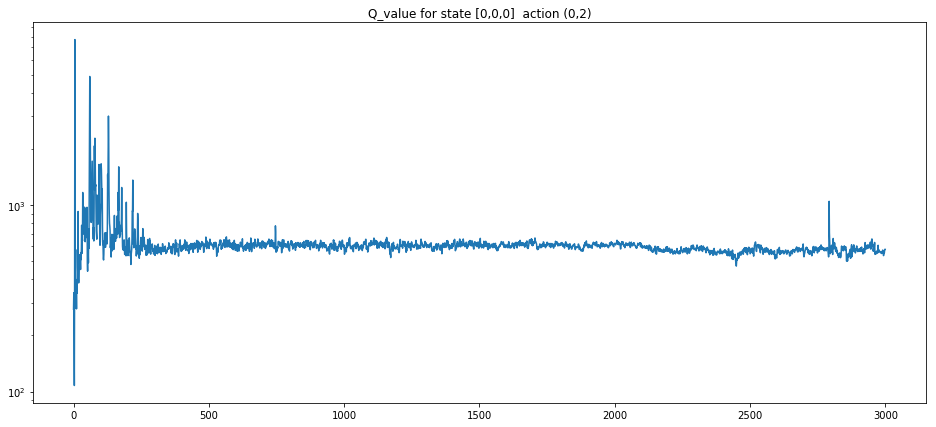

In [21]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### We are using log scale because the initial q_values are way to high compared to the steady state value (around 600)

### 6. Track rewards per episode.

In [11]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

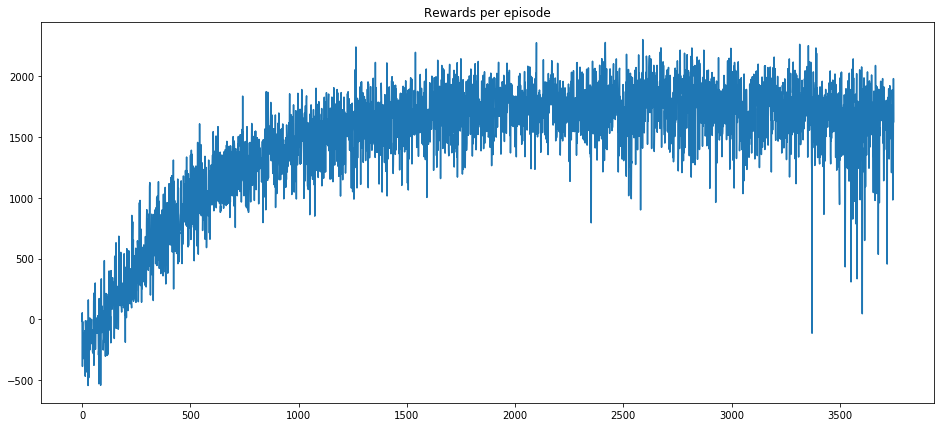

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

### We can see from the above plot that the rewards converge at around 1500. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.

#### Epsilon-decay sample function

In [18]:
import numpy as np
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

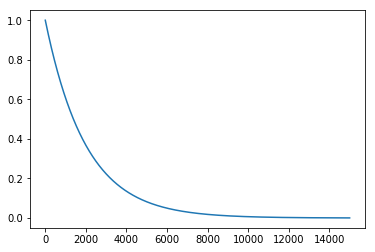

In [19]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()